<a href="https://colab.research.google.com/github/vincelemke99/Bachelor-Thesis/blob/main/lead_predication3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 30 17:41:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
SEED = 42

In [4]:
!pip install mlens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 5.5 MB/s eta 0:00:00


In [5]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Import necessary libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd



In [6]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated")

Authenticated


In [7]:
PROJECT_ID = 'prj-snd-ew3-vschmitt'

In [8]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

In [9]:
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'lead_prediction'
BQ_TABLE = 'trainings_data_converted'

In [10]:
# SQL query to select data
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""

try:
    # Execute the query and convert the result to a pandas DataFrame
    df = client.query(query=query).to_dataframe()
    print("Query executed successfully and DataFrame is ready.")
except Exception as e:
    print(f"An error occurred: {e}")


Query executed successfully and DataFrame is ready.


In [11]:
df.head()

,id,domain,name,has_phone,geschlecht,lead_source,produkt_zeitraum_c,produkt_art_der_ausbildung_c,product_interest_type,produkt_standort,produkt_fachbereich,produkt_name,semester,is_converted,count_leads
0,b6ccd310-cc76-4810-9e84-8f87bba6dddf,gmail.com,normal,True,weiblich,Publisher,Vollzeit,Master,None,Wien,None,None,None,False,1
1,c9402f96-519a-4f13-a89f-75e71754d8bb,gmail.com,normal,False,männlich,Publisher,Vollzeit,Bachelor,None,Wien,None,None,None,False,1
2,029806d1-5b30-442f-97bc-39e3e7de3b3e,krendl.at,normal,False,weiblich,Messe,Vollzeit,Bachelor,None,Wien,Fachbereich Nachhaltigkeit,"Psychologie, B.Sc.",Sommersemester,False,1
3,c2aae326-1fe7-4bd9-9d39-44b763347799,seznam.cz,normal,True,weiblich,Direkt,Vollzeit,Bachelor,Infomaterial,Wien,Fachbereich Nachhaltigkeit,"Psychologie, B.Sc.",Sommersemester,False,1
4,85add168-42b2-4a08-b85f-fc7db54decd9,icloud.com,normal,False,männlich,Paid SEM,Vollzeit,Bachelor,Infomaterial,Wien,Fachbereich Nachhaltigkeit,"Psychologie, B.Sc.",Sommersemester,False,2


In [12]:
df.shape

(121986, 15)

In [13]:
df.drop(['id',], axis="columns", inplace=True)
df.head()

,domain,name,has_phone,geschlecht,lead_source,produkt_zeitraum_c,produkt_art_der_ausbildung_c,product_interest_type,produkt_standort,produkt_fachbereich,produkt_name,semester,is_converted,count_leads
0,gmail.com,normal,True,weiblich,Publisher,Vollzeit,Master,None,Wien,None,None,None,False,1
1,gmail.com,normal,False,männlich,Publisher,Vollzeit,Bachelor,None,Wien,None,None,None,False,1
2,krendl.at,normal,False,weiblich,Messe,Vollzeit,Bachelor,None,Wien,Fachbereich Nachhaltigkeit,"Psychologie, B.Sc.",Sommersemester,False,1
3,seznam.cz,normal,True,weiblich,Direkt,Vollzeit,Bachelor,Infomaterial,Wien,Fachbereich Nachhaltigkeit,"Psychologie, B.Sc.",Sommersemester,False,1
4,icloud.com,normal,False,männlich,Paid SEM,Vollzeit,Bachelor,Infomaterial,Wien,Fachbereich Nachhaltigkeit,"Psychologie, B.Sc.",Sommersemester,False,2


In [14]:
df.rename(columns={'geschlecht' : 'gender', 'produkt_zeitraum_c' : 'study_model',
       'produkt_art_der_ausbildung_c' : 'type_of_study_programme', 'produkt_standort' : 'Study_location',
       'produkt_fachbereich' : 'faculty', 'produkt_name': 'Study_programme',
       'product_interest_type' : 'Conversion_type'},inplace=True)
df.head()

,domain,name,has_phone,gender,lead_source,study_model,type_of_study_programme,Conversion_type,Study_location,faculty,Study_programme,semester,is_converted,count_leads
0,gmail.com,normal,True,weiblich,Publisher,Vollzeit,Master,None,Wien,None,None,None,False,1
1,gmail.com,normal,False,männlich,Publisher,Vollzeit,Bachelor,None,Wien,None,None,None,False,1
2,krendl.at,normal,False,weiblich,Messe,Vollzeit,Bachelor,None,Wien,Fachbereich Nachhaltigkeit,"Psychologie, B.Sc.",Sommersemester,False,1
3,seznam.cz,normal,True,weiblich,Direkt,Vollzeit,Bachelor,Infomaterial,Wien,Fachbereich Nachhaltigkeit,"Psychologie, B.Sc.",Sommersemester,False,1
4,icloud.com,normal,False,männlich,Paid SEM,Vollzeit,Bachelor,Infomaterial,Wien,Fachbereich Nachhaltigkeit,"Psychologie, B.Sc.",Sommersemester,False,2


In [15]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Conversion_type,24501
gender,3023
domain,900
Study_programme,669
faculty,669
semester,669
has_phone,204
study_model,0
name,0
lead_source,0


In [16]:
df['Conversion_type'].value_counts()

Conversion_type
Infomaterial    84188
Infoabend       13297
Name: count, dtype: int64

In [17]:
df['Conversion_type'] = df['Conversion_type'].fillna('Infomaterial')

In [18]:
df['gender'].value_counts()

gender
weiblich        77416
männlich        41091
keine Angabe      440
divers             16
Name: count, dtype: int64

In [19]:
df['gender'] = df['gender'].fillna('weiblich')

In [20]:
df['domain'].value_counts()

domain
gmail.com                       26827
web.de                          12055
gmx.de                          11761
icloud.com                       7933
t-online.de                      4861
                                ...  
hausverwaltung-goettfried.de        1
braun-immobilien.de                 1
denich-real.at                      1
kirschenbaum.email                  1
sparkasse-ffb.de                    1
Name: count, Length: 11470, dtype: int64

In [21]:
df['domain'] = df['domain'].fillna('gmail.com')

In [22]:
df['Study_programme'].value_counts()

Study_programme
Psychologie, B.Sc.                                                   13028
Wirtschaftspsychologie, B.Sc.                                         6579
Betriebswirtschaftslehre, B.A.                                        6279
Soziale Arbeit, B.A.                                                  3690
Physiotherapie, B.Sc.                                                 3331
                                                                     ...  
Angewandte Psychologie für Führungskräfte, M.A. weiterbildend            1
Master of Management in Artificial Intelligence, Economy, MMAI           1
Vorbereitungskurs Wirtschaft/Deutsch für Feststellungsprüfung            1
Wirtschaftsingenieurwesen Engineering und Automatisierung, M.Eng.        1
Insurance Management & Finance, M.Sc.                                    1
Name: count, Length: 219, dtype: int64

In [23]:
df['Study_programme'] = df['Study_programme'].fillna('Psychologie, B.Sc.')

In [24]:
df['faculty'].value_counts()

faculty
Fachbereich onlineplus                      39832
Fachbereich Wirtschaft & Medien             38825
Fachbereich Gesundheit & Soziales           18332
Fachbereich Design                          12240
Fachbereich Psychologie                      4377
Fachbereich Chemie & Biologie                4351
Fachbereich Exercise and Health Sciences     1545
Fachbereich Nachhaltigkeit                   1132
Fachbereich Management                        651
Fachbereich studienkolleg                      32
Name: count, dtype: int64

In [25]:
df['faculty'] = df['faculty'].fillna('Fachbereich onlineplus')

In [26]:
df['semester'].value_counts()

semester
Wintersemester    88926
Sommersemester    32391
Name: count, dtype: int64

In [27]:
df['semester'] = df['semester'].fillna('Wintersemester')

In [28]:
df['has_phone'].value_counts()

Conversion_type
Infomaterial    108689
Infoabend        13297
Name: count, dtype: int64

In [29]:
df['has_phone'] = df['has_phone'].fillna(True)

In [30]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
domain,0
name,0
has_phone,0
gender,0
lead_source,0
study_model,0
type_of_study_programme,0
Conversion_type,0
Study_location,0
faculty,0


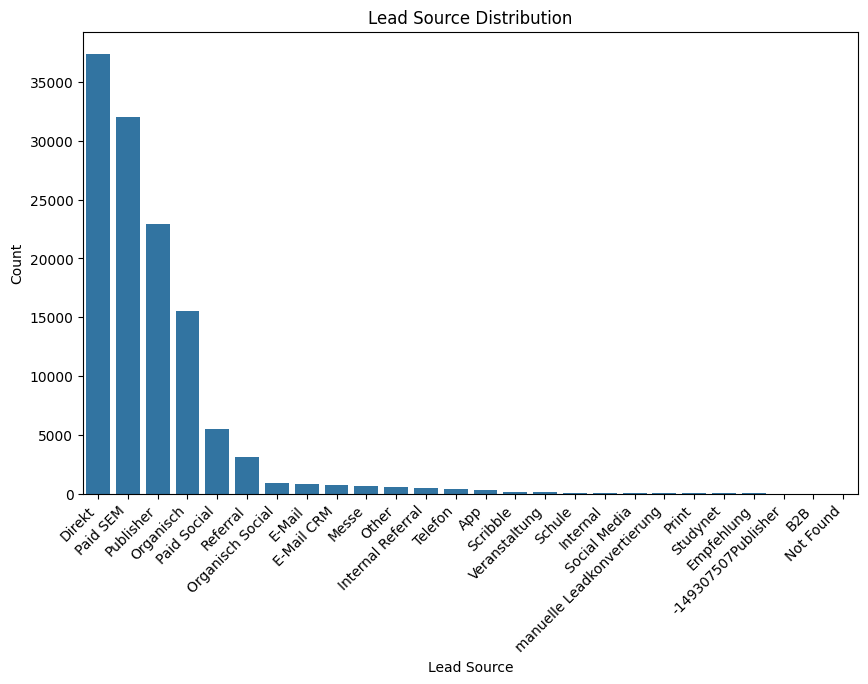

In [31]:

# 2. Lead Source Distribution
plt.figure(figsize=(10, 6))
lead_source_count = df['lead_source'].value_counts(dropna=False)
sns.barplot(x=lead_source_count.index, y=lead_source_count.values)
plt.title('Lead Source Distribution')
plt.xlabel('Lead Source')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


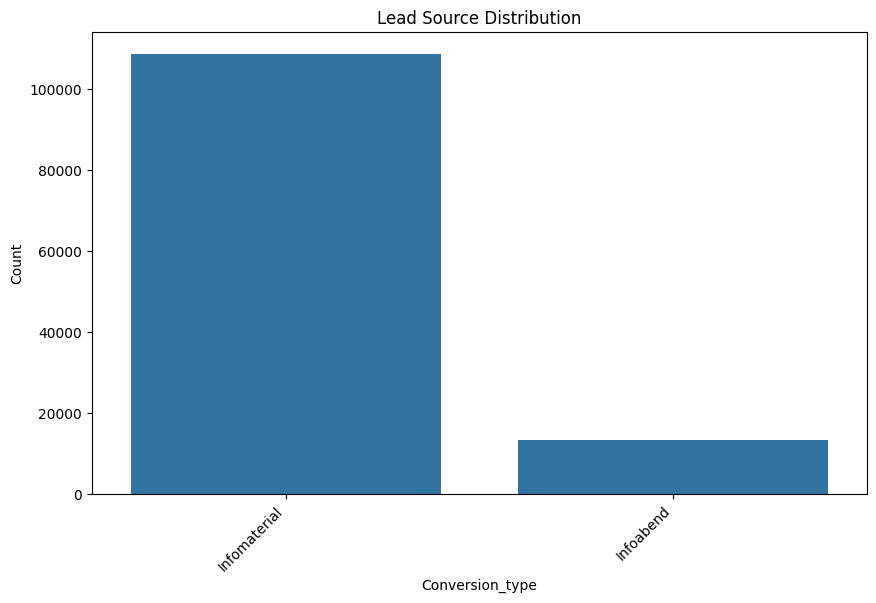

In [32]:
# 2. Conversion_type Distribution
plt.figure(figsize=(10, 6))
lead_source_count = df['Conversion_type'].value_counts()
sns.barplot(x=lead_source_count.index, y=lead_source_count.values)
plt.title('Lead Source Distribution')
plt.xlabel('Conversion_type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


In [33]:
from sklearn.preprocessing import LabelEncoder

# Determine categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = df.columns.values.tolist()
for col in features:
    if df[col].dtype in numerics: continue
    categorical_columns.append(col)

# Encode categorical features
for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

In [34]:
df.head()

,domain,name,has_phone,gender,lead_source,study_model,type_of_study_programme,Conversion_type,Study_location,faculty,Study_programme,semester,is_converted,count_leads
0,3695,1,1,3,17,4,3,1,17,8,170,1,0,0
1,3695,1,0,2,17,4,1,1,17,8,170,1,0,0
2,5893,1,0,3,9,4,1,1,17,5,170,0,0,0
3,9168,1,1,3,3,4,1,1,17,5,170,0,0,0
4,4792,1,0,2,14,4,1,1,17,5,170,0,0,50


In [35]:
X = df.copy()
y = X.pop("is_converted")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

In [36]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

has_phone                  0.053150
Study_programme            0.008000
count_leads                0.002269
semester                   0.001109
type_of_study_programme    0.000000
Name: MI Scores, dtype: float64

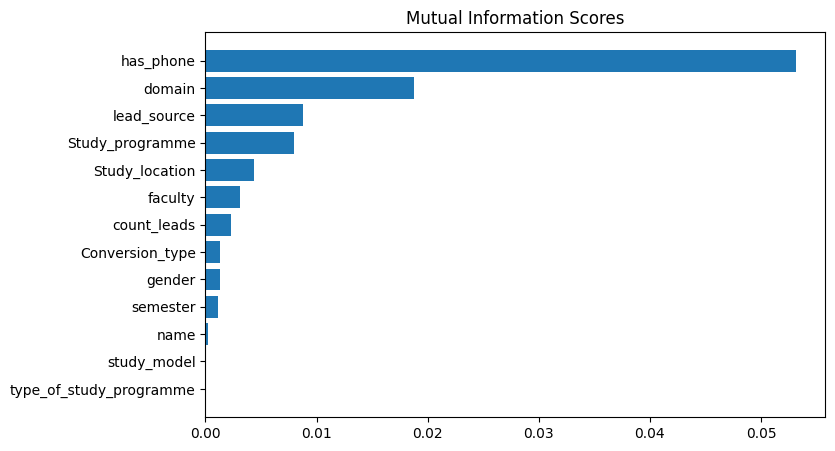

In [37]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [38]:
# Import necessary libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


In [39]:
# Load data
X = df.drop(columns=['is_converted'])
y = df['is_converted']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Define the models to be used
MLA = [
    DecisionTreeClassifier(),
    lgb.LGBMClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    xgb.XGBClassifier()
]

In [41]:
# Create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)

# Create table to compare MLA predictions
MLA_predict = y.copy()

# Index through MLA and save performance to table
row_index = 0
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    # Score model with cross-validation
    cv_results = cross_validate(alg, X, y, cv=cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std() * 3

    # Save MLA predictions
    alg.fit(X, y)
    MLA_predict[MLA_name] = alg.predict(X)

    row_index += 1

# Print and sort table
MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
print(MLA_compare)

NameError: name 'cross_validate' is not defined

In [ ]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import ShuffleSplit, cross_validate
vote_est = [

    ('gbc', GradientBoostingClassifier()),
    ('rfc', RandomForestClassifier()),
    ('dtc', DecisionTreeClassifier()),
    ('lgb', lgb.LGBMClassifier()),
    ('xgb', xgb.XGBClassifier())

]


#Hard Vote or majority rules
vote_hard = VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X,y, cv  = cv_split)
vote_hard.fit(X,y)

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100))
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, X,y cv  = cv_split)
vote_soft.fit(X,y)

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100))
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

In [ ]:
#WARNING: Running is very computational intensive and time expensive.
#Code is written for experimental/developmental purposes and not production ready!
import time

#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [

               # Decision Tree parameters
           [{
        'max_depth': grid_max_depth,
        'min_samples_split': grid_min_samples,
        'criterion': grid_criterion,
          'random_state': grid_seed
         }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3
            'random_state': grid_seed
             }],


            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],




            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator,
            'seed': grid_seed
             }]
                 [{
        'learning_rate': grid_learn,
        'num_leaves': [31, 50],
        'n_estimators': grid_n_estimator,
        'random_state': grid_seed
          }],
        ]



start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)


    start = time.perf_counter()
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(X,y)
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param)


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)